<a href="https://colab.research.google.com/github/YanivRefaelovich/ML-Projects/blob/master/Burglary%20Prediction/Prediction_of_Home_Burglary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Your task is to predict the number of home burglaries at Precinct no. 44 that will take place during the first 3 months of 2018

In [0]:
from google.colab import drive
drive.mount('/content/drive')


import os
os.chdir('drive/My Drive/Madlan Home Assignment')

os.listdir()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


['Data',
 'data_science_home_task_v2.pdf',
 'data_science_home_task_v2.gdoc',
 'Madlan Home Assignment.ipynb',
 'Madlan Home Assignment_2.ipynb']

# Importing

In [0]:
import pandas as pd
import seaborn as sns; sns.set(style="darkgrid", palette='muted')
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold, GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from itertools import product
import gc
import warnings; warnings.filterwarnings("ignore")

In [0]:
# reading data from csv
data = pd.read_csv('Data/NYPD_Complaint_Data_Historic.csv')

print('Done reading.')

Done reading.


In [0]:
data['ADDR_PCT_CD'] = data['ADDR_PCT_CD'].fillna(-1)
data=data.astype({'ADDR_PCT_CD': np.int32})

# fields description
CMPLNT_NUM Randomly generated persistent ID for each complaint

ADDR_PCT_CD The precinct in which the incident occurred 

BORO The name of the borough in which the incident occurred 

CMPLNT_FR_DT Exact date of occurrence for the reported event (or starting 
date of occurrence, if CMPLNT_TO_DT exists) 

CMPLNT_FR_TM Exact time of occurrence for the reported event (or starting 
time of occurrence, if CMPLNT_TO_TM exists) 

CMPLNT_TO_DT Ending date of occurrence for the reported event, if exact 
time of occurrence is unknown 

CMPLNT_TO_TM Ending time of occurrence for the reported event, if exact 
time of occurrence is unknown 

CRM_ATPT_CPTD_CD Indicator of whether crime was successfully completed or 
attempted, but failed or was interrupted prematurely

HADEVELOPT Name of NYCHA housing development of occurrence, if 
applicable 

HOUSING_PSA Development Level Code 
JURISDICTION_CODE 
Jurisdiction responsible for incident. Either internal, like Police(0), Transit(1), and Housing(2); or external(3), like Correction, Port Authority, etc. 

JURIS_DESC Description of the jurisdiction code 
KY_CD Three digit offense classification code 

LAW_CAT_CD Level of offense: felony, misdemeanor, violation 

LOC_OF_OCCUR_DESC Specific location of occurrence in or around the premises; 
inside, opposite of, front of, rear of 

OFNS_DESC Description of offense corresponding with key code 

PARKS_NM Name of NYC park, playground or greenspace of 
occurrence, if applicable (state parks are not included) 

PATROL_BORO The name of the patrol borough in which the incident 
occurred 

PD_CD Three digit internal classification code (more granular than 
Key Code) 

PD_DESC Description of internal classification corresponding with PD 
code (more granular than Offense Description) 

PREM_TYP_DESC Specific description of premises; grocery store, residence, 
street, etc.

RPT_DT Date event was reported to police 

STATION_NAME Transit station name 

SUSP_AGE_GROUP Suspect’s Age Group 

SUSP_RACE Suspect’s Race Description 

SUSP_SEX Suspect’s Sex Description 

TRANSIT_DISTRICT Transit district in which the offense occurred.

VIC_AGE_GROUP Victim’s Age Group 

VIC_RACE Victim’s Race Description 

VIC_SEX 
Victim’s Sex Description (D=Business/Organization, E=PSNY/People of the State of New York, F=Female, M=Male) 

X_COORD_CD X-coordinate for New York State Plane Coordinate System, 
Long Island Zone, NAD 83, units feet (FIPS 3104) 

Y_COORD_CD Y-coordinate for New York State Plane Coordinate System, 
Long Island Zone, NAD 83, units feet (FIPS 3104) 

Latitude Midblock Latitude coordinate for Global Coordinate System, 
WGS 1984, decimal degrees (EPSG 4326) 

Longitude Midblock Longitude coordinate for Global Coordinate 
System, WGS 1984, decimal degrees (EPSG 4326) 




In [0]:
data.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,JURISDICTION_CODE,PARKS_NM,HADEVELOPT,HOUSING_PSA,X_COORD_CD,Y_COORD_CD,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,577055921,12/31/2018,19:00:00,12/31/2018,19:35:00,75,12/31/2018,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,AGGRAVATED HARASSMENT 2,COMPLETED,MISDEMEANOR,BROOKLYN,INSIDE,RESIDENCE - PUBLIC HOUSING,N.Y. HOUSING POLICE,2.0,NaN,EAST NEW YORK CITY LINE,348,"1,019,655","182,468",<18,BLACK,F,NaN,40.667447,-73.872377,"(40.667446665, -73.872377258)",PATROL BORO BKLYN NORTH,NaN,18-24,BLACK,M
1,311304275,12/31/2018,15:00:00,12/31/2018,16:00:00,41,12/31/2018,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,COMPLETED,MISDEMEANOR,BRONX,INSIDE,STREET,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,"1,015,845","236,500",25-44,WHITE HISPANIC,F,NaN,40.815765,-73.885857,"(40.815765327, -73.885857339)",PATROL BORO BRONX,NaN,18-24,WHITE HISPANIC,F
2,427481098,12/31/2018,18:00:00,12/31/2018,18:30:00,14,12/31/2018,109,GRAND LARCENY,410.0,"LARCENY,GRAND FROM RETAIL STORE, UNATTENDED",COMPLETED,FELONY,MANHATTAN,INSIDE,CLOTHING/BOUTIQUE,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,"988,318","212,070",NaN,NaN,NaN,NaN,40.748767,-73.985320,"(40.748767014, -73.985319659)",PATROL BORO MAN SOUTH,NaN,18-24,UNKNOWN,F
3,212387335,12/31/2018,16:50:00,12/31/2018,17:00:00,81,12/31/2018,106,FELONY ASSAULT,109.0,"ASSAULT 2,1,UNCLASSIFIED",ATTEMPTED,FELONY,BROOKLYN,INSIDE,RESIDENCE - APT. HOUSE,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,"1,006,734","188,708",25-44,BLACK,M,NaN,40.684616,-73.918933,"(40.684616294, -73.918932657)",PATROL BORO BKLYN NORTH,NaN,25-44,BLACK,M
4,629543587,12/31/2018,00:45:00,12/31/2018,01:00:00,26,12/31/2018,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,COMPLETED,MISDEMEANOR,MANHATTAN,INSIDE,OTHER,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,"994,261","232,730",18-24,BLACK,F,NaN,40.805469,-73.963840,"(40.805468548, -73.963840045)",PATROL BORO MAN NORTH,NaN,25-44,WHITE HISPANIC,M


In [0]:
data['Start_Time'] = pd.to_datetime(data['CMPLNT_FR_DT'] , format='%m/%d/%Y', errors='coerce')


print('number of lines couldnt convert to datetime:  ', data['Start_Time'].isnull().sum())
print(data.loc[data['Start_Time'].isnull(), ['CMPLNT_FR_DT', 'CMPLNT_TO_DT',	'CMPLNT_FR_TM']].tail())

# in case date is nan- i will take the CMPLNT_TO_DT columns
data.loc[data['Start_Time'].isnull(), 'Start_Time'] = pd.to_datetime(data.loc[data['Start_Time'].isnull(), 'CMPLNT_TO_DT']  , format='%m/%d/%Y', errors='coerce')


print('now, number of lines couldnt convert to datetime:  ', data['Start_Time'].isnull().sum())
print(data.loc[data['Start_Time'].isnull(), ['CMPLNT_TO_DT','CMPLNT_TO_DT',	'CMPLNT_FR_TM']].tail())

# remove these lines

data = data.drop(np.where(data['Start_Time'].isnull())[0], axis=0).reset_index(drop=True)

print('finaly, number of lines couldnt convert to datetime:  ', data['Start_Time'].isnull().sum())


number of lines couldnt convert to datetime:   751
        CMPLNT_FR_DT CMPLNT_TO_DT CMPLNT_FR_TM
6500865          NaN          NaN     18:00:00
6500866          NaN   11/21/2014     23:55:00
6500867          NaN          NaN     17:50:00
6500868          NaN   02/20/2011     09:25:00
6500869          NaN   03/06/2015     01:00:00
now, number of lines couldnt convert to datetime:   173
        CMPLNT_TO_DT CMPLNT_TO_DT CMPLNT_FR_TM
6500856          NaN          NaN     15:00:00
6500861          NaN          NaN     11:00:00
6500863          NaN          NaN     17:00:00
6500865          NaN          NaN     18:00:00
6500867          NaN          NaN     17:50:00
finaly, number of lines couldnt convert to datetime:   0


In [0]:
data['Month'] = data['Start_Time'].dt.month
data['Year'] = data['Start_Time'].dt.year
data['DOW'] = data['Start_Time'].dt.weekday
data['Counts']=1

# 1. EDA and visualization

**Study the data a little bit before you suggest a method of prediction.**

**What did you check?**

**Did you find anything interesting**

In [0]:
data['Year'].unique()

array([2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008,
       2007, 2006, 2005, 2004, 2003, 2002, 2001, 2000, 1999, 1998, 1997,
       1996, 1995, 1994, 1993, 1992, 1991, 1990, 1989, 1988, 1987, 1986,
       1985, 1984, 1983, 1982, 1981, 1980, 1979, 1978, 1977, 1976, 1975,
       1974, 1973, 1972, 1971, 1970, 1969, 1968, 1967, 1966, 1965, 1964,
       1962, 1961, 1960, 1959, 1958, 1957, 1956, 1955, 1954, 1951, 1950,
       1948, 1947, 1946, 1945, 1942, 1941, 1940, 1938, 1930, 1929, 1928,
       1922, 1920, 1919, 1918, 1917, 1916, 1915, 1914, 1913, 1912, 1911,
       1910, 1909, 1908, 1906, 1905, 1900])

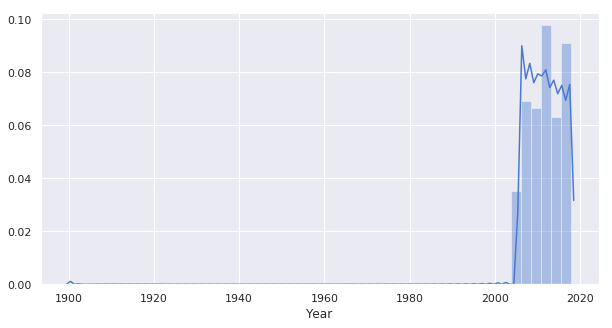

In [0]:
plt.subplots(figsize=(10,5))
sns.distplot(data['Year']);
# i will take all information between years 2007-2017
# year 2018 will remain as validation as it the target of this task

data = data.drop(np.where(data['Year'].lt(2015))[0], axis=0)



There are few rows from not relevant years that are probably a mistake.

I will use data from 2007 and further.

** update **

I saw that with that amount of data of previous 10 years (2007-2017) is too much for the model to learn, because the behaviour of 2007 not necessaruly will be like 2018. 

So I thought that taking data that is not so far from the time I want to predict will have better results.

So I took data of the past 3 years (2015-2017).

In [0]:
data['Year'].unique()
data.shape

(1875769, 40)

In [0]:
data.isnull().sum()

CMPLNT_NUM                 0
CMPLNT_FR_DT              15
CMPLNT_FR_TM               0
CMPLNT_TO_DT          308491
CMPLNT_TO_TM          307655
ADDR_PCT_CD                0
RPT_DT                     0
KY_CD                      0
OFNS_DESC               1254
PD_CD                   1231
PD_DESC                 1231
CRM_ATPT_CPTD_CD           0
LAW_CAT_CD                 0
BORO_NM                 1250
LOC_OF_OCCUR_DESC     368976
PREM_TYP_DESC           7714
JURIS_DESC                 0
JURISDICTION_CODE       1231
PARKS_NM             1857781
HADEVELOPT           1781398
HOUSING_PSA          1729907
X_COORD_CD               130
Y_COORD_CD               130
SUSP_AGE_GROUP        622478
SUSP_RACE             517186
SUSP_SEX              517186
TRANSIT_DISTRICT     1828739
Latitude                 130
Longitude                130
Lat_Lon                  130
PATROL_BORO             1231
STATION_NAME         1828739
VIC_AGE_GROUP         107129
VIC_RACE                   3
VIC_SEX       

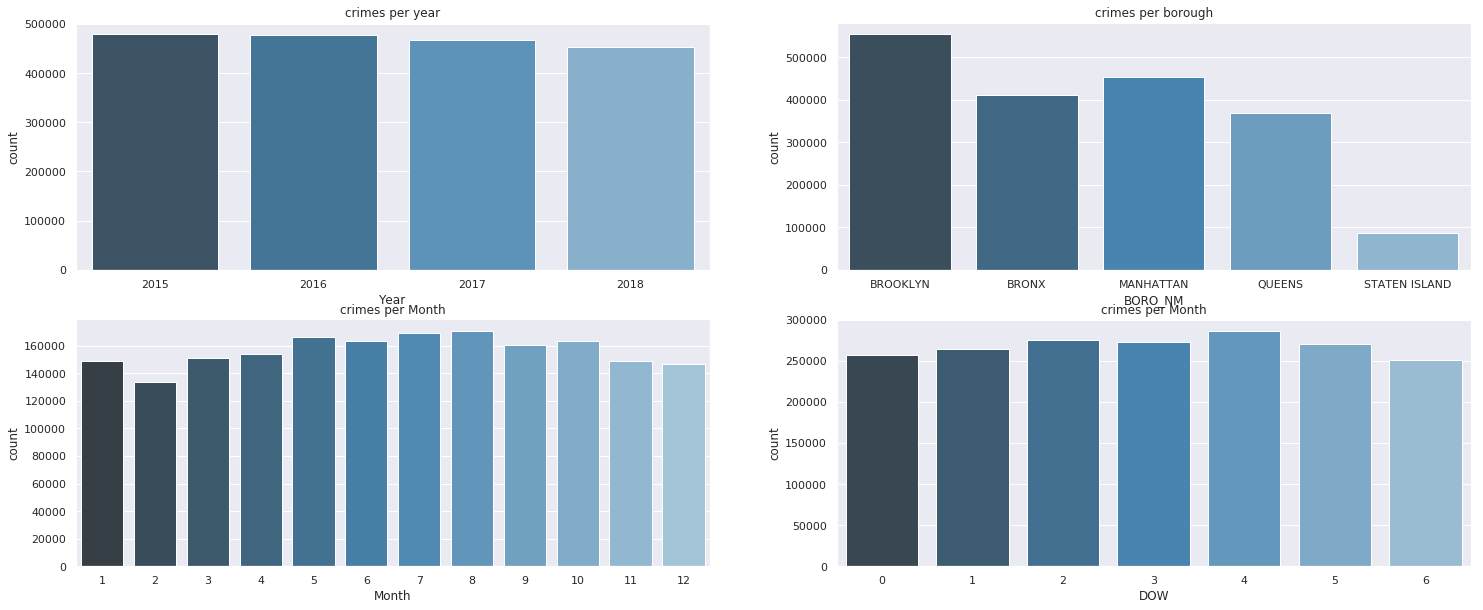

In [0]:
f, axes = plt.subplots(2,2, figsize=(25,10))
axes = axes.flatten()
sns.countplot(x="Year",data=data, ax=axes[0], palette='Blues_d')
axes[0].set_title('crimes per year');

sns.countplot(x="BORO_NM",data=data, ax=axes[1], palette='Blues_d')
axes[1].set_title('crimes per borough');

sns.countplot(x="Month",data=data, ax=axes[2], palette='Blues_d')
axes[2].set_title('crimes per Month');

sns.countplot(x="DOW",data=data, ax=axes[3], palette='Blues_d')
axes[3].set_title('crimes per Month');

there is a decrease in number of crimes over the year.  well done NYPD!

there is a big difference between boroughs - can be usefull information and optional features.

Also, we can see some seasonality during the year

and seasonality over the week 

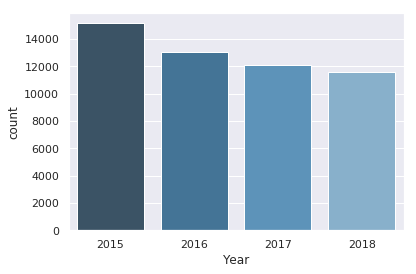

In [0]:
sns.countplot(x="Year",data=data.loc[data['OFNS_DESC']=='BURGLARY',:], palette='Blues_d')


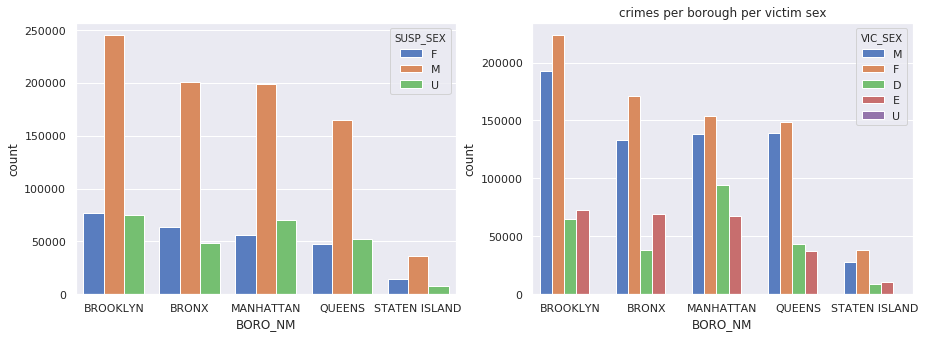

In [0]:
f, axes = plt.subplots(1,2,figsize=(15,5))# fig=plt.figure(figsize=(5, 3), dpi= 80, facecolor='w', edgecolor='k')

sns.countplot(x="BORO_NM", hue='SUSP_SEX', data=data, ax=axes[0])
plt.title('crimes per borough per suspect sex');

# fig=plt.figure(figsize=(5, 3), dpi= 80, facecolor='w', edgecolor='k')
sns.countplot(x="BORO_NM", hue='VIC_SEX', data=data, ax=axes[1])
plt.title('crimes per borough per victim sex');

Most of the attackers are males. most of the victims are females.

Maybe we can look on correlation of proportion of males to the amoung of crimes

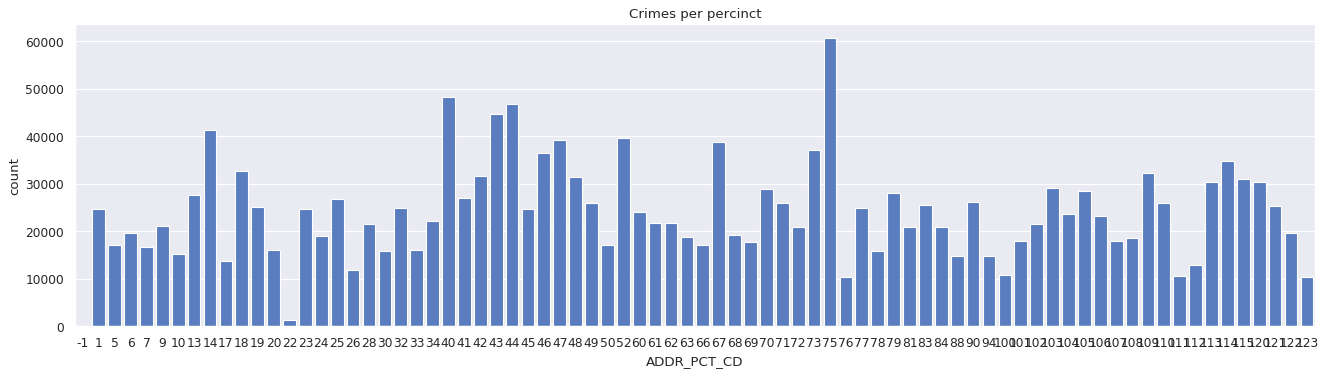

In [0]:
fig=plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = sns.countplot(x="ADDR_PCT_CD", data=data, color='b')
plt.title('Crimes per percinct');


There is a large varience betweem different precints.

No. 44 is among the ones with alot of crimes

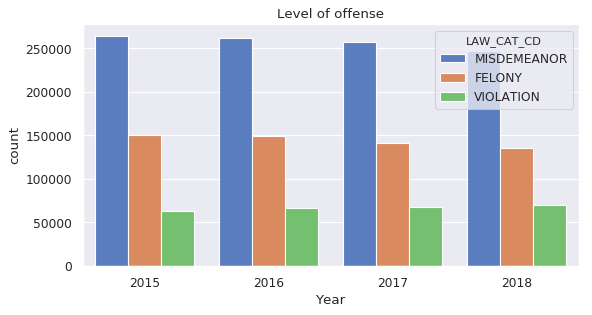

In [0]:
fig=plt.figure(figsize=(8, 4), dpi= 80, facecolor='w', edgecolor='k')
ax = sns.countplot(x="Year", hue="LAW_CAT_CD", data=data)
plt.title('Level of offense');

Most of offenses are clasified as Misdemeanor

In [0]:
data = data.drop(np.where(data['ADDR_PCT_CD']==-1)[0], axis=0)
data = data.reset_index(drop=True)
(data['ADDR_PCT_CD']==-1).sum()

0

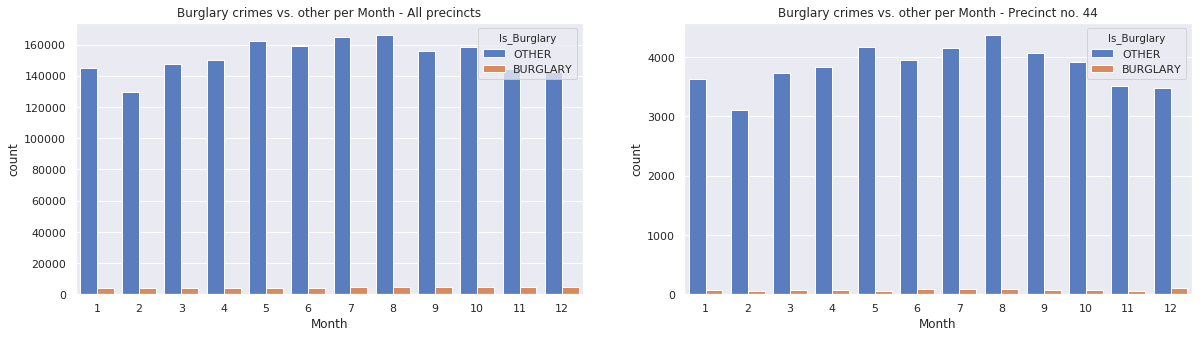

In [0]:
data['Is_Burglary'] = data['OFNS_DESC'].copy()
data.loc[data['Is_Burglary']!='BURGLARY', 'Is_Burglary'] = 'OTHER'

f, axes= plt.subplots(1,2, figsize=(20, 5))
sns.countplot(x="Month", hue='Is_Burglary', data=data, ax = axes[0])
axes[0].set_title('Burglary crimes vs. other per Month - All precincts');

data_44 = data.loc[data['ADDR_PCT_CD']==44, :]

sns.countplot(x="Month",hue='Is_Burglary', data=data_44, ax=axes[1])
axes[1].set_title('Burglary crimes vs. other per Month - Precinct no. 44');


Among all crimes types - 'BURGLARY' is not that common

Same behavior happens also in precnct No. 44

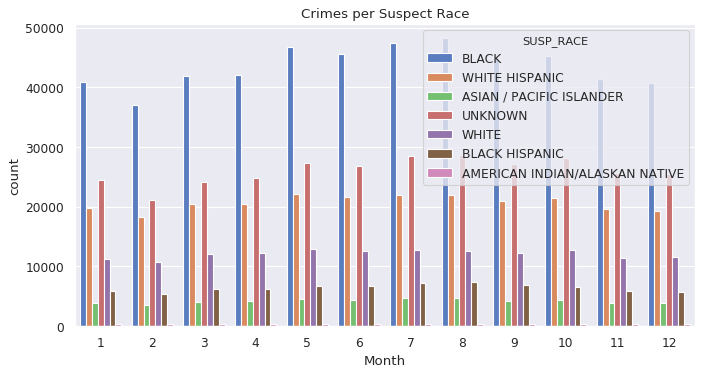

In [0]:
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = sns.countplot(x="Month", hue='SUSP_RACE', data=data)
plt.title('Crimes per Suspect Race');

We can see that most of the crimes were performed by black 

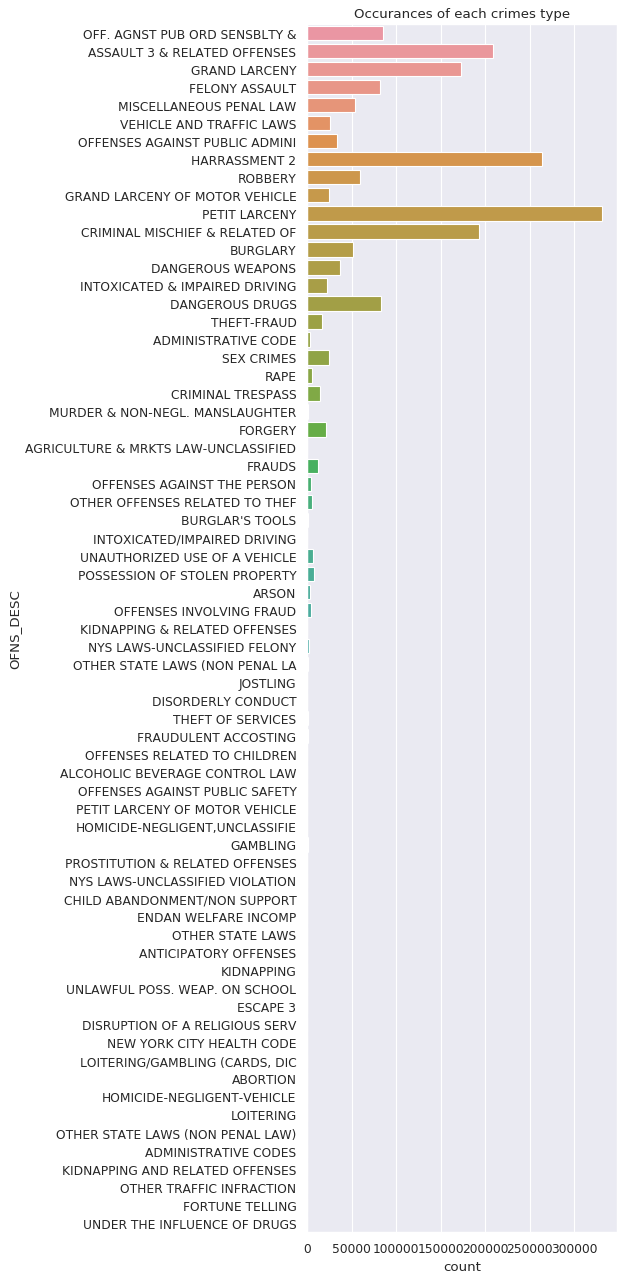

In [0]:
fig=plt.figure(figsize=(5, 20), dpi= 80, facecolor='w', edgecolor='k')
ax = sns.countplot(y="OFNS_DESC", data=data)
plt.title('Occurances of each crimes type');


In [0]:
data.loc[data['ADDR_PCT_CD']==44, ['ADDR_PCT_CD','BORO_NM']].drop_duplicates().head()

,ADDR_PCT_CD,BORO_NM
100,44,BRONX
16965,44,NaN
272419,44,MANHATTAN
312497,44,BROOKLYN
1700028,44,QUEENS


I saw that there are missing Boroughs names, in places that Precinct number does exist.

also, noticed that there are rows with the same Precinct number but different Borough name.

So I decided to create 1-to-1 map between Precinct and Borough and tranlate it with no duplicates

I tool the list from NYPD website

In [0]:
# missing neighberhood
print('num missing BORO_NM: ', data['BORO_NM'].isnull().sum())

#generate map from NYPD website 
# translating precint number to bourogh name
Manhattan = list(range(1, 35))
Bronx = list(range(40, 53))
Brooklyn = list(range(60, 95))
Queens = list(range(100, 116))
Staten_Island = list(range(120, 124))

d1 = dict.fromkeys(Manhattan, 'MANHATTAN')
d2 = dict.fromkeys(Bronx, 'BRONX')
d3 = dict.fromkeys(Brooklyn, 'BROOKLYN')
d4 = dict.fromkeys(Staten_Island, 'STATEN ISLAND')
d5 = dict.fromkeys(Queens, 'QUEENS')
Map = {**d1, **d2, **d3, **d4, **d5}

data['BORO_NM'] = data['ADDR_PCT_CD'].copy()
data['BORO_NM'] = data['BORO_NM'].map(Map)

print('num missing BORO_NM: ', data['BORO_NM'].isnull().sum())


num missing BORO_NM:  1247
num missing BORO_NM:  0


In [0]:
data.loc[data['ADDR_PCT_CD']==44, ['ADDR_PCT_CD','BORO_NM']].drop_duplicates()

,ADDR_PCT_CD,BORO_NM
100,44,BRONX


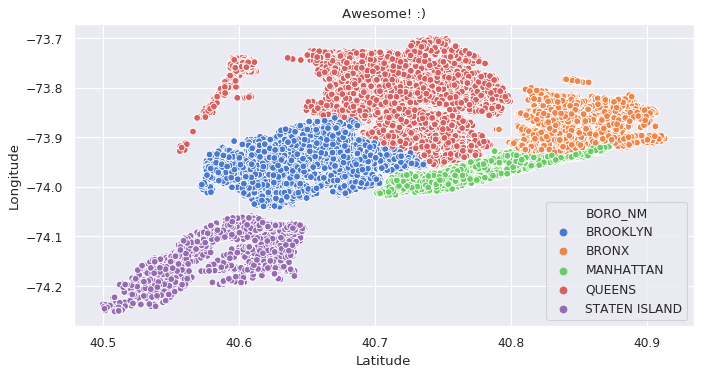

In [0]:
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')

sns.scatterplot(x= 'Latitude', y='Longitude', hue='BORO_NM', data=data.iloc[0:100000, :]);
plt.title('Awesome! :)');


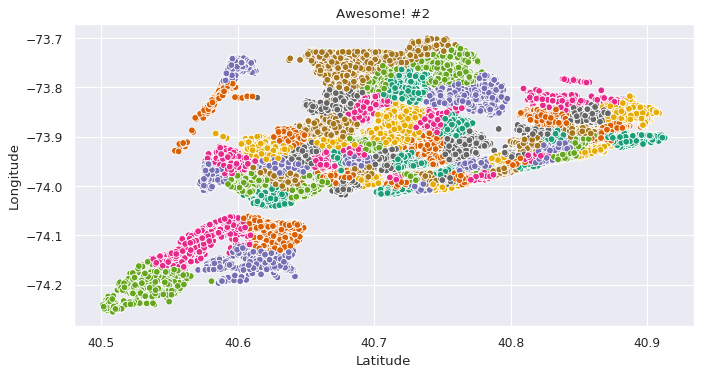

In [0]:
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')

palette = sns.color_palette(palette='Dark2', n_colors=data['ADDR_PCT_CD'].unique().shape[0], desat=None)

sns.scatterplot(x= 'Latitude', y='Longitude', hue='ADDR_PCT_CD', data=data.iloc[1000000:1100000, :], legend=False, palette=palette);
plt.title('Awesome! #2');


In [0]:
# generating pivot matrix
pivot = pd.pivot_table(data, values='Counts', index=['Year','Month'], columns=['OFNS_DESC'], aggfunc='count').reset_index().fillna(0)
corr = pivot.corr()
pivot.head()

OFNS_DESC,Year,Month,ABORTION,ADMINISTRATIVE CODE,ADMINISTRATIVE CODES,AGRICULTURE & MRKTS LAW-UNCLASSIFIED,ALCOHOLIC BEVERAGE CONTROL LAW,ANTICIPATORY OFFENSES,ARSON,ASSAULT 3 & RELATED OFFENSES,BURGLAR'S TOOLS,BURGLARY,CHILD ABANDONMENT/NON SUPPORT,CRIMINAL MISCHIEF & RELATED OF,CRIMINAL TRESPASS,DANGEROUS DRUGS,DANGEROUS WEAPONS,DISORDERLY CONDUCT,DISRUPTION OF A RELIGIOUS SERV,ENDAN WELFARE INCOMP,ESCAPE 3,FELONY ASSAULT,FORGERY,FORTUNE TELLING,FRAUDS,FRAUDULENT ACCOSTING,GAMBLING,GRAND LARCENY,GRAND LARCENY OF MOTOR VEHICLE,HARRASSMENT 2,"HOMICIDE-NEGLIGENT,UNCLASSIFIE",HOMICIDE-NEGLIGENT-VEHICLE,INTOXICATED & IMPAIRED DRIVING,INTOXICATED/IMPAIRED DRIVING,JOSTLING,KIDNAPPING,KIDNAPPING & RELATED OFFENSES,KIDNAPPING AND RELATED OFFENSES,LOITERING,"LOITERING/GAMBLING (CARDS, DIC",MISCELLANEOUS PENAL LAW,MURDER & NON-NEGL. MANSLAUGHTER,NEW YORK CITY HEALTH CODE,NYS LAWS-UNCLASSIFIED FELONY,NYS LAWS-UNCLASSIFIED VIOLATION,OFF. AGNST PUB ORD SENSBLTY &,OFFENSES AGAINST PUBLIC ADMINI,OFFENSES AGAINST PUBLIC SAFETY,OFFENSES AGAINST THE PERSON,OFFENSES INVOLVING FRAUD,OFFENSES RELATED TO CHILDREN,OTHER OFFENSES RELATED TO THEF,OTHER STATE LAWS,OTHER STATE LAWS (NON PENAL LA,OTHER STATE LAWS (NON PENAL LAW),OTHER TRAFFIC INFRACTION,PETIT LARCENY,PETIT LARCENY OF MOTOR VEHICLE,POSSESSION OF STOLEN PROPERTY,PROSTITUTION & RELATED OFFENSES,RAPE,ROBBERY,SEX CRIMES,THEFT OF SERVICES,THEFT-FRAUD,UNAUTHORIZED USE OF A VEHICLE,UNDER THE INFLUENCE OF DRUGS,UNLAWFUL POSS. WEAP. ON SCHOOL,VEHICLE AND TRAFFIC LAWS
0,2015,1,0.0,75.0,0.0,0.0,3.0,0.0,98.0,3747.0,19.0,1181.0,3.0,3945.0,380.0,1422.0,836.0,3.0,1.0,1.0,1.0,1392.0,409.0,0.0,294.0,9.0,7.0,3271.0,514.0,4364.0,0.0,0.0,450.0,0.0,4.0,0.0,11.0,0.0,0.0,0.0,1010.0,38.0,1.0,40.0,0.0,1557.0,590.0,1.0,100.0,83.0,29.0,78.0,0.0,25.0,0.0,0.0,5854.0,8.0,130.0,5.0,118.0,1444.0,437.0,50.0,412.0,94.0,0.0,0.0,413.0
1,2015,2,1.0,70.0,0.0,0.0,9.0,0.0,89.0,3554.0,13.0,1004.0,1.0,3053.0,434.0,1731.0,728.0,2.0,1.0,1.0,1.0,1253.0,403.0,0.0,280.0,19.0,4.0,2758.0,449.0,3948.0,0.0,0.0,576.0,2.0,1.0,0.0,10.0,0.0,0.0,0.0,915.0,17.0,0.0,45.0,0.0,1417.0,586.0,3.0,74.0,95.0,16.0,119.0,1.0,30.0,0.0,0.0,4886.0,2.0,123.0,7.0,72.0,1048.0,330.0,42.0,437.0,106.0,0.0,0.0,400.0
2,2015,3,0.0,80.0,0.0,0.0,5.0,0.0,111.0,4195.0,24.0,1063.0,0.0,4090.0,428.0,1998.0,871.0,4.0,0.0,2.0,2.0,1569.0,511.0,0.0,408.0,13.0,7.0,3255.0,503.0,4803.0,2.0,0.0,585.0,1.0,2.0,0.0,9.0,0.0,0.0,0.0,1054.0,25.0,0.0,54.0,0.0,1739.0,774.0,5.0,86.0,121.0,7.0,104.0,2.0,35.0,0.0,0.0,6245.0,5.0,156.0,2.0,103.0,1187.0,451.0,54.0,531.0,109.0,0.0,1.0,505.0
3,2015,4,0.0,77.0,0.0,1.0,10.0,0.0,89.0,4166.0,22.0,1101.0,4.0,4611.0,389.0,2042.0,881.0,3.0,1.0,1.0,0.0,1607.0,466.0,1.0,356.0,21.0,17.0,3450.0,626.0,4945.0,0.0,0.0,526.0,0.0,0.0,0.0,12.0,0.0,0.0,1.0,1109.0,24.0,0.0,48.0,1.0,1696.0,875.0,4.0,107.0,116.0,14.0,127.0,0.0,30.0,0.0,2.0,6751.0,5.0,198.0,12.0,97.0,1202.0,414.0,49.0,499.0,128.0,1.0,0.0,452.0
4,2015,5,0.0,85.0,0.0,9.0,3.0,0.0,87.0,4979.0,22.0,1300.0,3.0,4605.0,349.0,1891.0,926.0,6.0,0.0,2.0,1.0,1876.0,414.0,0.0,278.0,15.0,40.0,3712.0,642.0,5697.0,1.0,0.0,518.0,0.0,7.0,0.0,13.0,0.0,0.0,0.0,1143.0,36.0,0.0,40.0,0.0,1770.0,910.0,6.0,134.0,83.0,8.0,107.0,0.0,30.0,0.0,0.0,7478.0,9.0,206.0,19.0,117.0,1441.0,500.0,50.0,422.0,150.0,0.0,0.0,550.0




---


generate pivot table for aggregating occurances of each year and month per crime type

this way I want to see if there is som correlation of number of crime per month between different crime types



---



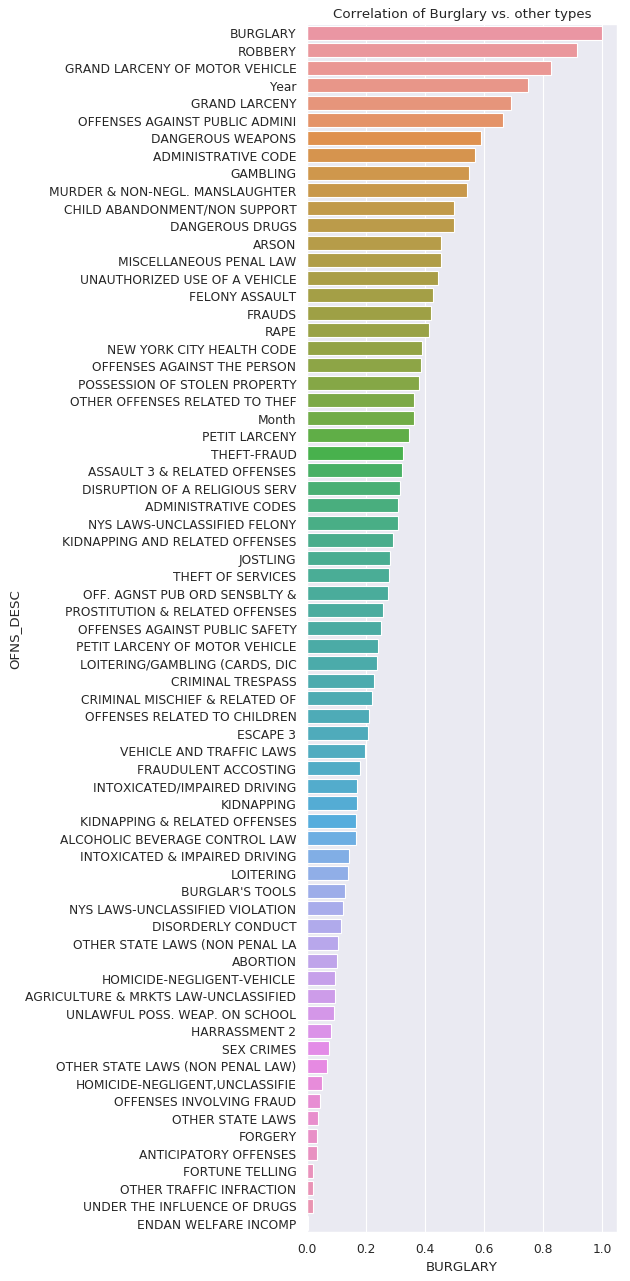

In [0]:
fig=plt.figure(figsize=(5, 20), dpi= 80, facecolor='w', edgecolor='k')
ax = sns.barplot(y="OFNS_DESC",x="BURGLARY", data=corr['BURGLARY'].abs().sort_values(ascending=False).reset_index())
plt.title('Correlation of Burglary vs. other types');

In [0]:
C = corr['BURGLARY'].abs().sort_values(ascending=False)
correlation_crimes = list(C.loc[C>0.8].index)
# correlation_crimes.remove('Year')

correlation_crimes

['BURGLARY', 'ROBBERY', 'GRAND LARCENY OF MOTOR VEHICLE']



---


we can wee that, for example, occurance of ROBBERY and AGRAND LARCENY OF MOTOR VEHICLE is highly correlated with occurences of BURGLARY

it can be a usefull feature for prediction of burglary


---



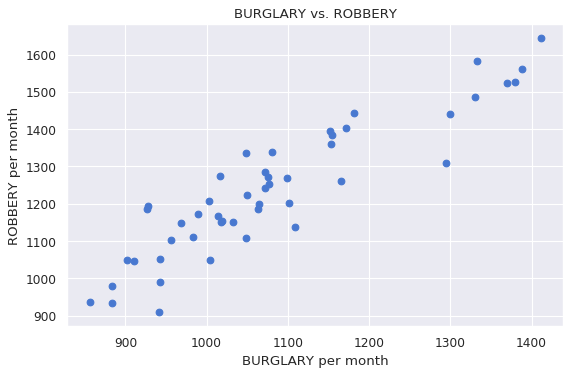

In [0]:
fig=plt.figure(figsize=(8, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(pivot['BURGLARY'].values, pivot['ROBBERY'].values,'o')
plt.title('BURGLARY vs. ROBBERY');
plt.xlabel('BURGLARY per month');
plt.ylabel('ROBBERY per month');

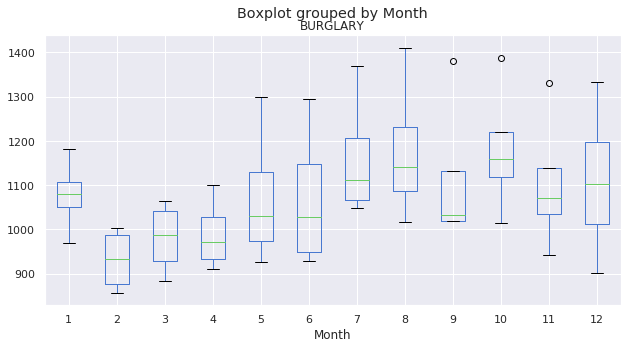

In [0]:

pivot.boxplot(column='BURGLARY', by='Month', figsize=(10,5));

Insights:
there is increase of BURGLARY incidents over months

# 2. Suggest at least two methods to perform the prediction

# Compare the methods you suggested. Please describe your methodology.

First way:


---


look only on precinct no. 44 over time.

aggregate burglarys occurences over months, and use simple model to fit these points.

the problem is that there gonna be just a few points (#years*12) and might result in poor model

second way:


---


look on all precinct. the idea is that we can lesan about no.44 also from other precincts.

taking as features the borouh_nm and location. and also other crimes occurences that can teach us about Burglary.


# 4. Choose one method and apply it -- what is your prediction for the first 3 months of 2018? quantify the quality of your method’s predictions.

I will chose the second method.

I will data from all precinct

I will use:

monthly occurences of Burglarys and other crimes that are correlated with BURGLARY (r>0.8)

information on month and dow

information on borogh

information on Latitude and Longitude


I will calculate:

previous [1, 2, 3, 4, 5, 6] for each month

sum of previous [3, 4, 6] months

std of previous [6, 12] months

sum over borougs over years

sum over boroughs over monhts




---


# Calculating Features for Model




In [0]:
# select the crimes with best correlation as features
cols=['Year','Month','Date_Num','ADDR_PCT_CD', 'BORO_NM'] + correlation_crimes
cols

['Year',
 'Month',
 'Date_Num',
 'ADDR_PCT_CD',
 'BORO_NM',
 'BURGLARY',
 'ROBBERY',
 'GRAND LARCENY OF MOTOR VEHICLE']

In [0]:
# generating skelaton for unique sets of (Year, Month, ADDR_PCT_CD, Date_Num)
matrix = pd.DataFrame(np.array(list(product(np.sort(data['Year'].unique()), np.sort(data['Month'].unique()), np.sort(data['ADDR_PCT_CD'].unique())   ))), columns=['Year','Month','ADDR_PCT_CD'])

# generating unique date_num for each (Year,Month) pair
Date_Num = np.arange(data['Year'].unique().shape[0]* data['Month'].unique().shape[0])
Date_Num = np.repeat(Date_Num, data['ADDR_PCT_CD'].unique().shape[0] )

matrix['Date_Num'] = Date_Num
matrix.shape

(3696, 4)

In [0]:
pivot_all = pd.pivot_table(data, values='Counts', index=['Year','Month','ADDR_PCT_CD','BORO_NM'], columns=['OFNS_DESC'], aggfunc='count').reset_index().fillna(0)
pivot_all.head()

OFNS_DESC,Year,Month,ADDR_PCT_CD,BORO_NM,ABORTION,ADMINISTRATIVE CODE,ADMINISTRATIVE CODES,AGRICULTURE & MRKTS LAW-UNCLASSIFIED,ALCOHOLIC BEVERAGE CONTROL LAW,ANTICIPATORY OFFENSES,ARSON,ASSAULT 3 & RELATED OFFENSES,BURGLAR'S TOOLS,BURGLARY,CHILD ABANDONMENT/NON SUPPORT,CRIMINAL MISCHIEF & RELATED OF,CRIMINAL TRESPASS,DANGEROUS DRUGS,DANGEROUS WEAPONS,DISORDERLY CONDUCT,DISRUPTION OF A RELIGIOUS SERV,ENDAN WELFARE INCOMP,ESCAPE 3,FELONY ASSAULT,FORGERY,FORTUNE TELLING,FRAUDS,FRAUDULENT ACCOSTING,GAMBLING,GRAND LARCENY,GRAND LARCENY OF MOTOR VEHICLE,HARRASSMENT 2,"HOMICIDE-NEGLIGENT,UNCLASSIFIE",HOMICIDE-NEGLIGENT-VEHICLE,INTOXICATED & IMPAIRED DRIVING,INTOXICATED/IMPAIRED DRIVING,JOSTLING,KIDNAPPING,KIDNAPPING & RELATED OFFENSES,KIDNAPPING AND RELATED OFFENSES,LOITERING,"LOITERING/GAMBLING (CARDS, DIC",MISCELLANEOUS PENAL LAW,MURDER & NON-NEGL. MANSLAUGHTER,NEW YORK CITY HEALTH CODE,NYS LAWS-UNCLASSIFIED FELONY,NYS LAWS-UNCLASSIFIED VIOLATION,OFF. AGNST PUB ORD SENSBLTY &,OFFENSES AGAINST PUBLIC ADMINI,OFFENSES AGAINST PUBLIC SAFETY,OFFENSES AGAINST THE PERSON,OFFENSES INVOLVING FRAUD,OFFENSES RELATED TO CHILDREN,OTHER OFFENSES RELATED TO THEF,OTHER STATE LAWS,OTHER STATE LAWS (NON PENAL LA,OTHER STATE LAWS (NON PENAL LAW),OTHER TRAFFIC INFRACTION,PETIT LARCENY,PETIT LARCENY OF MOTOR VEHICLE,POSSESSION OF STOLEN PROPERTY,PROSTITUTION & RELATED OFFENSES,RAPE,ROBBERY,SEX CRIMES,THEFT OF SERVICES,THEFT-FRAUD,UNAUTHORIZED USE OF A VEHICLE,UNDER THE INFLUENCE OF DRUGS,UNLAWFUL POSS. WEAP. ON SCHOOL,VEHICLE AND TRAFFIC LAWS
0,2015,1,1,MANHATTAN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,17.0,0.0,16.0,0.0,30.0,6.0,6.0,3.0,0.0,0.0,0.0,0.0,4.0,8.0,0.0,8.0,1.0,0.0,72.0,0.0,30.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,16.0,13.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,126.0,0.0,5.0,0.0,0.0,2.0,5.0,0.0,9.0,1.0,0.0,0.0,3.0
1,2015,1,5,MANHATTAN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,23.0,0.0,6.0,0.0,34.0,5.0,1.0,5.0,0.0,0.0,0.0,0.0,14.0,3.0,0.0,3.0,1.0,0.0,26.0,3.0,27.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,4.0,0.0,7.0,4.0,0.0,5.0,12.0,0.0,0.0,0.0,4.0,0.0,0.0,80.0,0.0,0.0,0.0,2.0,6.0,4.0,0.0,2.0,2.0,0.0,0.0,2.0
2,2015,1,6,MANHATTAN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,15.0,0.0,33.0,0.0,17.0,5.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,3.0,0.0,0.0,81.0,1.0,21.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,4.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,113.0,0.0,1.0,0.0,1.0,6.0,2.0,0.0,8.0,0.0,0.0,0.0,0.0
3,2015,1,7,MANHATTAN,0.0,0.0,0.0,0.0,0.0,0.0,2.0,36.0,0.0,7.0,0.0,51.0,6.0,13.0,4.0,0.0,0.0,0.0,0.0,16.0,5.0,0.0,2.0,0.0,0.0,34.0,1.0,44.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,12.0,3.0,0.0,2.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,26.0,1.0,0.0,0.0,0.0,17.0,5.0,0.0,3.0,0.0,0.0,0.0,0.0
4,2015,1,9,MANHATTAN,0.0,1.0,0.0,0.0,0.0,0.0,1.0,41.0,0.0,7.0,0.0,60.0,11.0,22.0,8.0,0.0,0.0,0.0,0.0,11.0,3.0,0.0,2.0,0.0,0.0,78.0,1.0,40.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,12.0,6.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,76.0,0.0,3.0,0.0,0.0,12.0,4.0,2.0,6.0,0.0,0.0,0.0,3.0


In [0]:
# dealing with duplicates in pivot_all
dupl = pivot_all.loc[pivot_all[['Year','Month','ADDR_PCT_CD']].duplicated(), ['Year',	'Month',	'ADDR_PCT_CD','BORO_NM']]

print('number of duplicates: ', dupl.shape[0])

number of duplicates:  0


In [0]:
X = matrix.merge(pivot_all, how='left', on=['Year','Month','ADDR_PCT_CD']).fillna(0)
X['BORO_NM'] = X['ADDR_PCT_CD'].map(Map)
X = X[cols]
X['BORO_NM'].unique()

array(['MANHATTAN', 'BRONX', 'BROOKLYN', 'QUEENS', 'STATEN ISLAND'],
      dtype=object)

Performing aggregarion and adding to the skelaton matrix

In [0]:
# aggregarion of Latitude as average over each month
pivot_latitude = pd.pivot_table(data, values='Latitude', index=['Year','Month','ADDR_PCT_CD','BORO_NM'], columns=['OFNS_DESC'], aggfunc='mean').reset_index().fillna(0)

X_Lat = matrix.merge(pivot_latitude, how='left',on=['Year','Month','ADDR_PCT_CD']).fillna(0)
X_Lat = X_Lat[cols]

X_Lat.columns = ['Year','Month','Date_Num','ADDR_PCT_CD', 'BORO_NM'] + [col+'_Lat' for col in correlation_crimes]
X_Lat['BORO_NM'] = X_Lat['ADDR_PCT_CD'].map(Map)


In [0]:
# aggregarion of Longitude as average over each month

pivot_longtitude = pd.pivot_table(data, values='Longitude', index=['Year','Month','ADDR_PCT_CD','BORO_NM'], columns=['OFNS_DESC'], aggfunc='mean').reset_index().fillna(0)

X_Long = matrix.merge(pivot_longtitude, how='left',on=['Year','Month','ADDR_PCT_CD']).fillna(0)
X_Long = X_Long[cols]

X_Long.columns = ['Year','Month','Date_Num','ADDR_PCT_CD', 'BORO_NM'] + [col+'_Long' for col in correlation_crimes]
X_Long['BORO_NM'] = X_Long['ADDR_PCT_CD'].map(Map)


In [0]:
# aggregarion of (Longitude^2 + Latitude^2) as standard deviation over each month


data['R'] = (data['Latitude'].values)**2 + (data['Longitude'].values)**2
pivot_R = pd.pivot_table(data, values='R', index=['Year','Month','ADDR_PCT_CD','BORO_NM'], columns=['OFNS_DESC'], aggfunc='std').reset_index().fillna(0)

X_R = matrix.merge(pivot_R, how='left',on=['Year','Month','ADDR_PCT_CD']).fillna(0)
X_R = X_R[cols]

X_R.columns = ['Year','Month','Date_Num','ADDR_PCT_CD', 'BORO_NM'] + [col+'_R' for col in correlation_crimes]
X_R['BORO_NM'] = X_R['ADDR_PCT_CD'].map(Map)


In [0]:
# aggregarion of day of weak as average over each month


pivot_DOW = pd.pivot_table(data, values='DOW', index=['Year','Month','ADDR_PCT_CD','BORO_NM'], columns=['OFNS_DESC'], aggfunc='mean').reset_index().fillna(0)

X_DOW = matrix.merge(pivot_DOW, how='left',on=['Year','Month','ADDR_PCT_CD']).fillna(0)
X_DOW = X_DOW[cols]

X_DOW.columns = ['Year','Month','Date_Num','ADDR_PCT_CD', 'BORO_NM'] + [col+'_DOW' for col in correlation_crimes]
X_DOW['BORO_NM'] = X_Long['ADDR_PCT_CD'].map(Map)

data.DOW.unique()

array([0, 6, 5, 4, 3, 2, 1])

In [0]:
# combining all X's
# X = X.merge(X_Lat, how='left', on=['Year','Month','Date_Num','ADDR_PCT_CD','BORO_NM']).fillna(0)
# X = X.merge(X_Long, how='left', on=['Year','Month','Date_Num','ADDR_PCT_CD','BORO_NM']).fillna(0)
X = X.merge(X_R, how='left', on=['Year','Month','Date_Num','ADDR_PCT_CD','BORO_NM']).fillna(0)
X = X.merge(X_DOW, how='left', on=['Year','Month','Date_Num','ADDR_PCT_CD','BORO_NM']).fillna(0)


X.head()

,Year,Month,Date_Num,ADDR_PCT_CD,BORO_NM,BURGLARY,ROBBERY,GRAND LARCENY OF MOTOR VEHICLE,BURGLARY_R,ROBBERY_R,GRAND LARCENY OF MOTOR VEHICLE_R,BURGLARY_DOW,ROBBERY_DOW,GRAND LARCENY OF MOTOR VEHICLE_DOW
0,2015,1,0,1,MANHATTAN,16.0,2.0,0.0,0.207062,0.318526,0.000000,3.000000,5.500000,0.000000
1,2015,1,0,5,MANHATTAN,6.0,6.0,3.0,0.325322,0.435421,0.267824,4.333333,3.333333,2.666667
2,2015,1,0,6,MANHATTAN,15.0,6.0,1.0,0.691742,0.686208,0.000000,2.933333,3.333333,1.000000
3,2015,1,0,7,MANHATTAN,7.0,17.0,1.0,0.566177,0.600406,0.000000,3.285714,3.294118,4.000000
4,2015,1,0,9,MANHATTAN,7.0,12.0,1.0,0.620012,0.999858,0.000000,2.428571,3.583333,6.000000


In [0]:
def shift_column(data=data, shift_values=[1], col_to_shift=['col1'], shift_by='col2', merge_on=['col3']):
# this function get df with specific column and shift value and add new column with the shifted column by the shift value  
  for i in shift_values:
    
    cols = merge_on.copy()
    cols.extend(col_to_shift)
    
    shifted = data[cols].copy()
    shifted[shift_by] += i

                   
    cols[-1]=col_to_shift[0] + '_' + str(i)
    shifted.columns = cols
    data = data.merge(shifted, on=merge_on, how='left')
  
  return data

  
#--------------------------------------------------------------------------------

def sum_prev_window(data=data, windows=[1], col_to_sum = 'BURGLARY', index='ADDR_PCT_CD', columns='Date_Num'):
# this function get a df and calculate sum of previous window and add it as new column
  
  
  for win in windows:
    
    tmp = data.pivot_table(values=col_to_sum, index=index, columns=columns).rolling(win, axis=1).sum().reset_index()
    sum_df = pd.DataFrame()

    for i in range(tmp.shape[1]):
      df = tmp.loc[:, ['ADDR_PCT_CD', i]].copy()
      df.columns = ['ADDR_PCT_CD', col_to_sum + '_sum' + str(win)]
      df['Date_Num'] = i
  
      sum_df = pd.concat([sum_df, df], axis=0, sort=False)
    
    data = data.merge(sum_df, how='left', on=[index, columns])
  
  
  return data

def std_prev_window(data=data, windows=[1], col_to_sum = 'BURGLARY', index='ADDR_PCT_CD', columns='Date_Num'):
# this function get a df and calculate std of previous window and add it as new column
  
  
  for win in windows:
    
    tmp = data.pivot_table(values=col_to_sum, index=index, columns=columns).rolling(win, axis=1).std().reset_index()
    sum_df = pd.DataFrame()

    for i in range(tmp.shape[1]):
      df = tmp.loc[:, ['ADDR_PCT_CD', i]].copy()
      df.columns = ['ADDR_PCT_CD', col_to_sum + '_std' + str(win)]
      df['Date_Num'] = i
  
      sum_df = pd.concat([sum_df, df], axis=0, sort=False)
    
    data = data.merge(sum_df, how='left', on=[index, columns])
  
  
  return data

# creating features with delay

calculating more aggregarions

In [0]:
gc.collect()
Features = X.copy()
correlation_crimes

cols_to_delay= Features.columns[5::]


# run over all columns and use functions above to calculate delay features
# add shifted information about each columns
for col in cols_to_delay:
  
  Features = shift_column(data=Features, shift_values=[1, 2, 3, 4, 5, 6], col_to_shift=[col], shift_by='Date_Num', merge_on=['Date_Num','ADDR_PCT_CD'])
  Features = sum_prev_window(Features, windows=[3, 4, 6, 12], col_to_sum=col, index='ADDR_PCT_CD', columns='Date_Num')
  Features = std_prev_window(Features, windows=[6, 12], col_to_sum=col, index='ADDR_PCT_CD', columns='Date_Num')


In [0]:
# add more aggregated information

# average over BORO_NM per month
cols = ['Date_Num','BORO_NM'] + correlation_crimes
group = X[cols].groupby(by=['Date_Num','BORO_NM'], as_index=False).mean()
group.columns=['Date_Num','BORO_NM'] + [col+'_boro_avg_month' for col in correlation_crimes]
Features = Features.merge(group, how='left', on=['Date_Num','BORO_NM'])

# average over BORO_NM per Year
cols = ['Year','BORO_NM'] + correlation_crimes
group = X[cols].groupby(by=['Year','BORO_NM'], as_index=False).mean()
group.columns=['Year','BORO_NM'] + [col+'_boro_avg_year' for col in correlation_crimes]
Features = Features.merge(group, how='left', on=['Year','BORO_NM'])

# average over ADDR_PCT_CD per Year
cols = ['Year','ADDR_PCT_CD'] + correlation_crimes
group = X[cols].groupby(by=['Year','ADDR_PCT_CD'], as_index=False).mean()
group.columns=['Year','ADDR_PCT_CD'] + [col+'_addr_pct_std_year' for col in correlation_crimes]
Features = Features.merge(group, how='left', on=['Year','ADDR_PCT_CD'])


In [0]:
Features.tail()

,Year,Month,Date_Num,ADDR_PCT_CD,BORO_NM,BURGLARY,ROBBERY,GRAND LARCENY OF MOTOR VEHICLE,BURGLARY_R,ROBBERY_R,GRAND LARCENY OF MOTOR VEHICLE_R,BURGLARY_DOW,ROBBERY_DOW,GRAND LARCENY OF MOTOR VEHICLE_DOW,BURGLARY_1,BURGLARY_2,BURGLARY_3,BURGLARY_4,BURGLARY_5,BURGLARY_6,BURGLARY_sum3,BURGLARY_sum4,BURGLARY_sum6,BURGLARY_sum12,BURGLARY_std6,BURGLARY_std12,ROBBERY_1,ROBBERY_2,ROBBERY_3,ROBBERY_4,ROBBERY_5,ROBBERY_6,ROBBERY_sum3,ROBBERY_sum4,ROBBERY_sum6,ROBBERY_sum12,ROBBERY_std6,ROBBERY_std12,GRAND LARCENY OF MOTOR VEHICLE_1,GRAND LARCENY OF MOTOR VEHICLE_2,...,BURGLARY_DOW_6,BURGLARY_DOW_sum3,BURGLARY_DOW_sum4,BURGLARY_DOW_sum6,BURGLARY_DOW_sum12,BURGLARY_DOW_std6,BURGLARY_DOW_std12,ROBBERY_DOW_1,ROBBERY_DOW_2,ROBBERY_DOW_3,ROBBERY_DOW_4,ROBBERY_DOW_5,ROBBERY_DOW_6,ROBBERY_DOW_sum3,ROBBERY_DOW_sum4,ROBBERY_DOW_sum6,ROBBERY_DOW_sum12,ROBBERY_DOW_std6,ROBBERY_DOW_std12,GRAND LARCENY OF MOTOR VEHICLE_DOW_1,GRAND LARCENY OF MOTOR VEHICLE_DOW_2,GRAND LARCENY OF MOTOR VEHICLE_DOW_3,GRAND LARCENY OF MOTOR VEHICLE_DOW_4,GRAND LARCENY OF MOTOR VEHICLE_DOW_5,GRAND LARCENY OF MOTOR VEHICLE_DOW_6,GRAND LARCENY OF MOTOR VEHICLE_DOW_sum3,GRAND LARCENY OF MOTOR VEHICLE_DOW_sum4,GRAND LARCENY OF MOTOR VEHICLE_DOW_sum6,GRAND LARCENY OF MOTOR VEHICLE_DOW_sum12,GRAND LARCENY OF MOTOR VEHICLE_DOW_std6,GRAND LARCENY OF MOTOR VEHICLE_DOW_std12,BURGLARY_boro_avg_month,ROBBERY_boro_avg_month,GRAND LARCENY OF MOTOR VEHICLE_boro_avg_month,BURGLARY_boro_avg_year,ROBBERY_boro_avg_year,GRAND LARCENY OF MOTOR VEHICLE_boro_avg_year,BURGLARY_addr_pct_std_year,ROBBERY_addr_pct_std_year,GRAND LARCENY OF MOTOR VEHICLE_addr_pct_std_year
3691,2018,12,47,115,QUEENS,8.0,13.0,3.0,1.736930,2.023940,1.405636,2.625000,3.461538,5.333333,11.0,9.0,10.0,17.0,17.0,14.0,28.0,38.0,72.0,192.0,4.000000,5.559594,18.0,18.0,17.0,29.0,32.0,13.0,49.0,66.0,127.0,248.0,7.521081,6.958753,9.0,15.0,...,3.142857,8.877525,11.977525,18.565761,36.601278,0.324220,0.292818,3.111111,4.388889,3.235294,3.551724,3.000000,2.846154,10.961538,14.196833,20.748557,40.027838,0.501008,0.397925,2.111111,3.000000,3.050000,3.000000,1.400000,3.0,10.444444,13.494444,17.894444,38.612393,1.326289,1.019718,11.5,12.25,6.625,12.802083,13.125000,7.817708,16.000000,20.666667,12.083333
3692,2018,12,47,120,STATEN ISLAND,13.0,14.0,4.0,2.281733,2.008705,1.472543,2.846154,4.428571,3.500000,13.0,8.0,6.0,12.0,13.0,9.0,34.0,40.0,65.0,151.0,3.060501,3.579191,11.0,16.0,12.0,12.0,15.0,12.0,41.0,53.0,80.0,147.0,1.966384,2.864358,2.0,4.0,...,2.888889,8.538462,10.038462,15.442308,34.347828,0.610608,0.614605,2.454545,2.750000,2.166667,3.083333,3.533333,2.333333,9.633117,11.799784,18.416450,32.600577,0.819483,0.854358,3.000000,3.750000,2.625000,2.833333,2.666667,3.0,10.250000,12.875000,18.375000,37.191667,0.462293,0.968001,8.5,6.25,3.750,7.437500,6.729167,3.791667,12.583333,12.250000,5.083333
3693,2018,12,47,121,STATEN ISLAND,11.0,7.0,7.0,2.706910,1.809338,2.406984,2.727273,1.571429,5.000000,6.0,10.0,10.0,7.0,7.0,8.0,27.0,37.0,51.0,95.0,2.073644,1.928652,15.0,12.0,13.0,7.0,16.0,8.0,34.0,47.0,70.0,123.0,3.881580,3.768892,4.0,2.0,...,2.750000,7.593939,10.993939,17.136797,33.861797,0.474681,0.450548,2.733333,1.416667,3.153846,3.142857,2.750000,3.625000,5.721429,8.875275,14.768132,34.034799,0.772609,0.876539,2.750000,4.000000,0.250000,2.000000,2.333333,2.6,11.750000,12.000000,16.333333,32.701190,1.649635,1.521002,8.5,6.25,3.750,7.437500,6.729167,3.791667,7.916667,10.250000,3.666667
3694,2018,12,47,122,STATEN ISLAND,7.0,4.0,3.0,3.433058,4.048726,3.067794,4.428571,1.250000,5.000000,5.0,14.0,7.0,6.0,4.0,11.0,26.0,33.0,43.0,88.0,3.544949,3.025147,0.0,3.0,4.0,2.0,2.0,6.0,7.0,11.0,15.0,42.0,1.516575,1.623688,7.0,5.0,...,4.090909,11.300000,14.585714,18.835714,40.012338,0.996358,0.898313,0.000000,1.666667,2.500000,4.000000,3.500000,4.166667,2.916667,5.416667,12.916667,33.200000,1.485501,1.345982,2.142857,3.200000,1.000000,3.666667,3.000000,2.0,10.342857,11.342857,18.009524,36.509524,1.357875,1.566788,8.5,6.25,3.750,7.437500,6.729167,3.791667,7.3



---


Creating the true label of each sample as the sum of the following 3 month


In [0]:
# Creating the true label of each sample as the sum of the following 3 month

tmp = X.pivot_table(values='BURGLARY', index='ADDR_PCT_CD',columns='Date_Num').rolling(3, axis=1).sum().reset_index()

Target = pd.DataFrame()

for i in range(tmp.shape[1]):
  df = tmp.loc[:, ['ADDR_PCT_CD', i]].copy()
  df.columns = ['ADDR_PCT_CD', 'Target']
  df['Date_Num'] = i-3
  
  Target = pd.concat([Target, df], axis=0, sort=False)

Target = matrix.merge(Target, how='left', on=['ADDR_PCT_CD','Date_Num'])




---


! for prediction of 3 month of 2018 i need to take Features of Year==2017 & Month==12


---



In [0]:
# arranging data for training

X_train = Features.copy()
y_train = Target['Target'].copy()

# remove index with target nan or Featues nan
inds_to_remove = np.concatenate((np.where(y_train.isnull())[0],  np.where(X_train.isnull().sum(axis=1)!=0)[0]))

X_train = X_train.drop(inds_to_remove, axis=0).reset_index(drop=True)
y_train = y_train.drop(inds_to_remove, axis=0).reset_index(drop=True)
 
print(X_train.shape, y_train.shape)

# encoding BORO_NM
le = LabelEncoder()
X_train['BORO_NM'] = le.fit_transform(X_train['BORO_NM'])

# take 2018 as validation and not participate in the trainint
val_inds=np.where((X_train['Year']==2018) | ((X_train['Year']==2017)&(X_train['Month']==12))  )[0]

X_val = X_train.iloc[val_inds,:];
y_val = y_train.iloc[val_inds]

y_train = y_train.drop(val_inds, axis=0)
X_train = X_train.drop(val_inds, axis=0)

data_for_2018_3_month = (X_val,y_val)

X_train = X_train.drop(['Year',	'Date_Num',	'ADDR_PCT_CD'], axis=1)
X_val = X_val.drop(['Year',	'Date_Num',	'ADDR_PCT_CD'], axis=1)

X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)




(2618, 131) (2618,)
(1848, 128) (1848,) (770, 128) (770,)


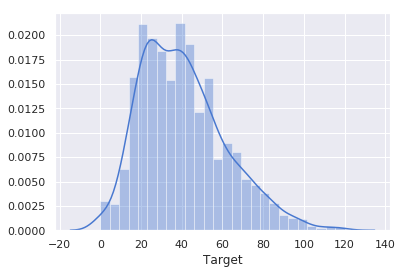

In [0]:
sns.distplot(y_train);

Target values are imbalanced. 

We may see greater error in the month with big amount of burglary



---

# Grid Seach with Feature Selection

Steps:

1. run grid search with all features
2. evaluate feature importance of the best_estimator of the grid
3. select only the best features, discard worst 25%
4. run grid again
5. stop when no improvement was present
6. take best params

In [0]:
# grid search for xgb with feature selecting


best_score = 100
columns_to_use = X_train.columns

while(True):
  # perform grid search
  xgb_param_grid={'objective':['reg:squarederror'],
              'max_depth': [3, 5, 7],
              'n_estimators': [ 200, 400],
              'reg_alpha': [1, 2],
              'reg_lambda': [1,2],
              'gamma': [1, 2],
              'lr': [0.1]
             }

  gb = xgb.XGBRegressor()

  cv = KFold(n_splits=5, random_state=42, shuffle=True)

  xgb_grid = GridSearchCV(gb, xgb_param_grid, cv=cv, scoring='neg_mean_squared_error'); # neg_mean_squared_error, neg_mean_absolute_error
  xgb_grid.fit(X_train[columns_to_use], y_train);
  
  
  current_best = np.sqrt(xgb_grid.best_score_*-1)
  
  # take only the best fetures, nd run grid search again
  if current_best<best_score:
    print('Current best: ', current_best ,' is better than previous: ' , best_score, '. Lets continue!')
    best_score = current_best
    best_estimator = xgb_grid.best_estimator_
    best_features = columns_to_use
    best_params = xgb_grid.best_params_

    # take only the better half of features
    feature_importance = best_estimator.feature_importances_
    columns_to_use = columns_to_use[feature_importance>np.percentile(feature_importance,25)]
    

  else:
    
    print('Stop.')
    break
  
print('Best params :', best_params)

Current best:  7.5896270701529405  is better than previous:  100 . Lets continue!
Current best:  7.3585864475742655  is better than previous:  7.5896270701529405 . Lets continue!
Current best:  7.0948616669347455  is better than previous:  7.3585864475742655 . Lets continue!
Current best:  6.875563750693177  is better than previous:  7.0948616669347455 . Lets continue!
Current best:  6.814829227361666  is better than previous:  6.875563750693177 . Lets continue!
Current best:  6.713104671126086  is better than previous:  6.814829227361666 . Lets continue!
Stop.
Best params : {'gamma': 1, 'lr': 0.1, 'max_depth': 7, 'n_estimators': 400, 'objective': 'reg:squarederror', 'reg_alpha': 2, 'reg_lambda': 2}


In [0]:
# predicting with the best model found

y_pred_train_xgb = best_estimator.predict(X_train[best_features])
y_pred_val_xgb = best_estimator.predict(X_val[best_features])

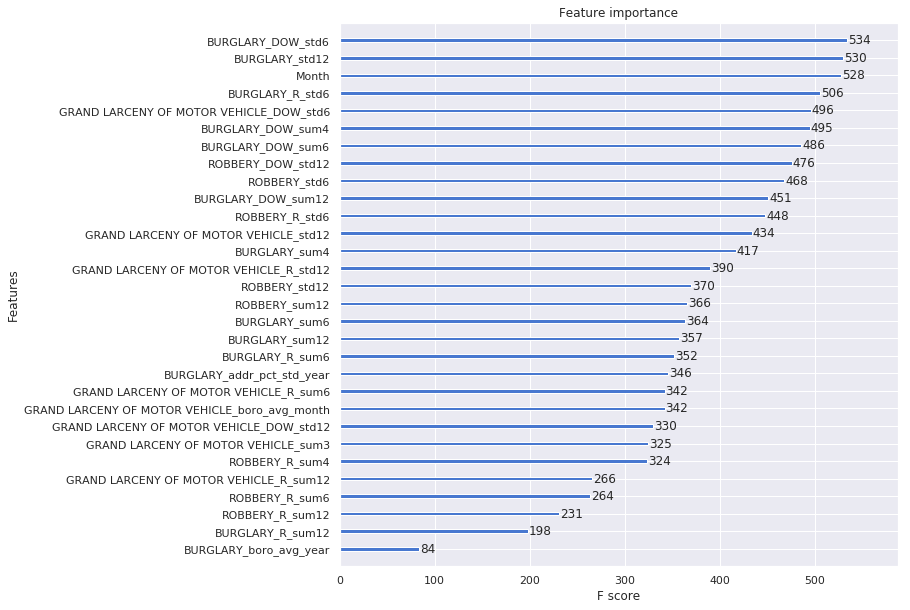

In [0]:
# look at the best features selected
ax=xgb.plot_importance(best_estimator);
fig = ax.figure
fig.set_size_inches(10, 10)


These are the feature that were chosen eventualy through the process.

interestingly, information about Day of week, was good contributor for the model.

Month also seems to be a good feature, and it does make sense



---


# Predicting the first 3 month of 2018

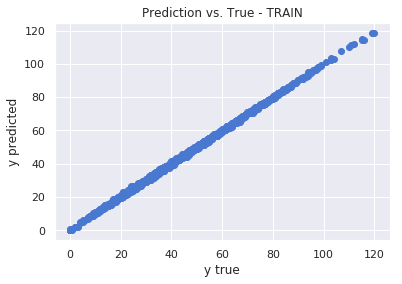

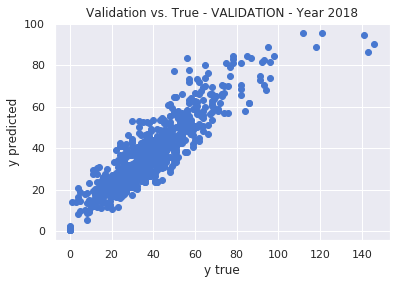

In [0]:
plt.figure()
plt.plot(y_train.values, y_pred_train_xgb, 'o')
plt.title('Prediction vs. True - TRAIN');
plt.xlabel('y true');
plt.ylabel('y predicted');

# plt.figure()
# plt.plot(y_train.iloc[test_inds].values, y_pred_test_xgb, 'o')
# plt.title('Prediction vs. True - TEST');
# plt.xlabel('y true');
# plt.ylabel('y predicted');


plt.figure()
plt.plot(y_val.values, y_pred_val_xgb, 'o')
plt.title('Validation vs. True - VALIDATION - Year 2018');
plt.xlabel('y true');
plt.ylabel('y predicted');

In [0]:
val_rmse=np.sqrt(np.mean((y_val - y_pred_val_xgb)**2))
val_mae=np.mean(np.abs((y_val - y_pred_val_xgb)))

print('RMSE over validation set of 2018 is: ', val_rmse)
print('MAE over validation set of 2018 is: ', val_mae)

RMSE over validation set of 2018 is:  8.736444481572438
MAE over validation set of 2018 is:  6.33906460493416


In [0]:
print('Best Parameters are: ', best_params)

Best Parameters are:  {'gamma': 1, 'lr': 0.1, 'max_depth': 7, 'n_estimators': 400, 'objective': 'reg:squarederror', 'reg_alpha': 2, 'reg_lambda': 2}


# Final results - prediction of first 3 month of 2018

In [0]:
x = data_for_2018_3_month[0]
y=data_for_2018_3_month[1]

ind = np.where((x['Year']==2017)&(x['Month']==12)&(x['ADDR_PCT_CD']==44))[0]

print('Predicted :',  y_pred_val_xgb[ind][0], '  , True :' ,y.iloc[ind].values[0])


Predicted : 61.16296   , True : 68.0




---



---



---



# 6. I am looking for a home to live in. I wish to compare different neighborhoods of the city, and see
which ones are less risky in terms of home burglaries. Please suggest a short plan for doing this.
What are the possible limitations of using this dataset for comparison?
Are there any additional kinds of data that you think I should use?



In order to do this kind of comparison I suggest to provide different information about history of home burglaries 

and a model that predict future ones.

for comparison, I sugget tp create some sort of metric that combine these peaces of information and says simply which one is better

Additional data sources that can be usefull:

1. weather information (snow, temp, rain...)
2. holidays
3. Demographic information of population in these neighborhoods (age, social-economic state...)
4. information of neighborhood's boundary

